In [1]:
pip install twython

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stopwordsiso


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px
import stopwordsiso as stopwords


import string
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yussy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yussy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yussy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
'''
load data
'''
df = pd.read_csv("C:/Users/yussy/temp/clean_data/unclean-data.csv")

In [3]:
df = df.drop(columns= 'socio_aspect')

In [4]:
df.head()

,username,comment,date_posted,Unnamed: 4,platform
0,mikepapafoxtrot,Unfortunately govt clinics do not open on week...,2024-05-07 05:47:11,NaN,reddit
1,Vezral,You can't claim private dental to be overprice...,2024-05-07 06:09:01,NaN,reddit
2,lalat_1881,I think that opinion is quite popular in this sub,2024-05-07 06:13:48,NaN,reddit
3,VapeGodz,Their skills and charges is not the main probl...,2024-05-07 06:21:54,NaN,reddit
4,NaN,"You can’t really compare the 2, it’s like appl...",2024-05-07 06:32:19,NaN,reddit


In [9]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()                     

,features,dtypes,NaN count,NaN percentage
0,username,object,1237,0.184324
1,comment,object,0,0.000000
2,date_posted,object,162,0.024139
3,Unnamed: 4,float64,6711,1.000000
4,platform,object,0,0.000000


In [11]:
df.duplicated().sum()

161

In [53]:
duplicated_rows = df[df.duplicated()]
print(duplicated_rows)


                  username                                            comment  \
66         mikepapafoxtrot  Unfortunately govt clinics do not open on week...   
67                  Vezral  You can't claim private dental to be overprice...   
68              lalat_1881  I think that opinion is quite popular in this sub   
69                VapeGodz  Their skills and charges is not the main probl...   
70                     NaN  You can’t really compare the 2, it’s like appl...   
...                    ...                                                ...   
3051  drinkup-glugglugglug  Catering towards the mentally handicapped such...   
3052          pmmeurpeepee  > Arguing for the sake if argument \n\nits the...   
3053          pmmeurpeepee  so autism get free pass?so autistic will be ac...   
3054  drinkup-glugglugglug  🤣 im an introvert in fact I spend my time alon...   
3055  drinkup-glugglugglug  Wow your brain must be tiny the way you jump t...   

              date_posted  

In [13]:
df.drop_duplicates(inplace=True)


In [15]:
df.columns

Index(['username', 'comment', 'date_posted', 'Unnamed: 4', 'platform'], dtype='object')

In [17]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

username: 4127 distinct values
comment: 6476 distinct values
date_posted: 3536 distinct values
Unnamed: 4: 1 distinct values
platform: 2 distinct values


In [22]:
'''
Feature Engineering
'''
df = df.drop(columns='username')

In [24]:
df['platform'].value_counts()

platform
tiktok    3520
reddit    3030
Name: count, dtype: int64

In [26]:
df['platform'] = df['platform'].str.strip()

In [28]:
'''
timestamp
'''
df['date_posted'] = pd.to_datetime(df['date_posted'], format='mixed', dayfirst=True, errors='coerce')


In [30]:
df['Month_num'] = df['date_posted'].dt.month
df['Year'] = df['date_posted'].dt.year
df['Year'] = df['Year'].astype('Int64')
df['Month_num'] = df['Month_num'].astype('Int64')

In [32]:
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month_name'] = df['Month_num'].map(month_mapping)


In [34]:
# Combine month name and year
df['Month_Year'] = df.apply(
    lambda x: f"{x['Month_name']} {x['Year']}" if pd.notnull(x['date_posted']) else 'Unknown',
    axis=1
)

# Optional: convert to object type
df['Month_Year'] = df['Month_Year'].astype('object')


In [36]:
df

,comment,date_posted,Unnamed: 4,platform,Month_num,Year,Month_name,Month_Year
0,Unfortunately govt clinics do not open on week...,2024-05-07 05:47:11,NaN,reddit,5,2024,May,May 2024
1,You can't claim private dental to be overprice...,2024-05-07 06:09:01,NaN,reddit,5,2024,May,May 2024
2,I think that opinion is quite popular in this sub,2024-05-07 06:13:48,NaN,reddit,5,2024,May,May 2024
3,Their skills and charges is not the main probl...,2024-05-07 06:21:54,NaN,reddit,5,2024,May,May 2024
4,"You can’t really compare the 2, it’s like appl...",2024-05-07 06:32:19,NaN,reddit,5,2024,May,May 2024
...,...,...,...,...,...,...,...,...
6706,I’m so motivated and glad I found ur page Jeff...,2024-03-25 00:00:00,NaN,tiktok,3,2024,March,March 2024
6707,boycott kings we have too many here so pdrm ha...,2024-03-25 00:00:00,NaN,tiktok,3,2024,March,March 2024
6708,nak keluar keluarla..pmx dah bawak berbilion l...,2024-03-24 00:00:00,NaN,tiktok,3,2024,March,March 2024
6709,"it's okay...we boikot first, eat grass and san...",2024-03-24 00:00:00,NaN,tiktok,3,2024,March,March 2024


In [72]:
# Malay internet slang stopwords
slang_stopwords = {
    'yg', 'sy', 'awk', 'x', 'dh', 'blh', 'je', 'dgn', 'sbb', 'tp', 'tu',
    'ni', 'la', 'knp', 'tgh', 'jgk', 'nk', 'kpd', 'klu', 'lg', 'brp', 'aku', 'u'
}


stemmer = PorterStemmer()
english_stopwords  = set(nltk_stopwords.words('english'))
malay_stopwords = set(stopwords.stopwords("ms"))  # "ms" is the ISO code for Malay

# Combine them
combined_stopwords = english_stopwords.union(malay_stopwords, slang_stopwords)


def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in combined_stopwords]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

df["clean_comment"] = df["comment"].apply(clean)

In [74]:
specified_columns = ['platform', 'Month_num', 'Year', 'Month_name',
       'Month_Year']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.YELLOW, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n') 

Total unique values for platform: 2
tiktok: 3520
reddit: 3030


Total unique values for Month_num: 12
12: 1047
6: 994
5: 643
10: 626
4: 594
8: 526
9: 508
3: 493
1: 358
11: 231
2: 193
7: 175


Total unique values for Year: 9
2024: 2103
2023: 2023
2022: 884
2025: 745
2021: 373
2020: 104
2017: 102
2018: 43
2019: 11


Total unique values for Month_name: 12
December: 1047
June: 994
May: 643
October: 626
April: 594
August: 526
September: 508
March: 493
January: 358
November: 231
February: 193
July: 175


Total unique values for Month_Year: 43
December 2023: 682
June 2023: 564
June 2024: 356
April 2025: 352
August 2023: 305
May 2024: 263
October 2024: 249
December 2024: 240
September 2021: 229
March 2024: 219
April 2024: 213
May 2023: 191
May 2022: 189
January 2025: 189
March 2025: 170
January 2024: 166
Unknown: 162
February 2022: 150
October 2022: 147
October 2023: 146
July 2024: 139
August 2024: 139
November 2022: 136
September 2023: 114
March 2020: 104
December 2017: 102
September 2022: 94

In [76]:
'''
EDA
'''
df1 = df.copy()


In [78]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['clean_comment'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['clean_comment', 'Vader_Score', 'Sentiment']].head())

                                       clean_comment  Vader_Score Sentiment
0   unfortun govt clinic open weekend public holiday       0.4019  positive
1  cant claim privat dental overpr pay rm scale o...      -0.5423  negative
2                     think opinion quit popular sub       0.4215  positive
3  skill charg main problem though talk friend ex...       0.2732  positive
4  cant realli compar like appl v orang govt clin...       0.0890  positive


In [87]:
# Save df1 to a CSV file
df1.to_csv("sentiment.csv", index=False, encoding='utf-8')
df1.to_excel ("sentiment.xlsx", index=False) 

print("✅ CSV file saved as 'sentiment.csv'")


✅ CSV file saved as 'sentiment.csv'


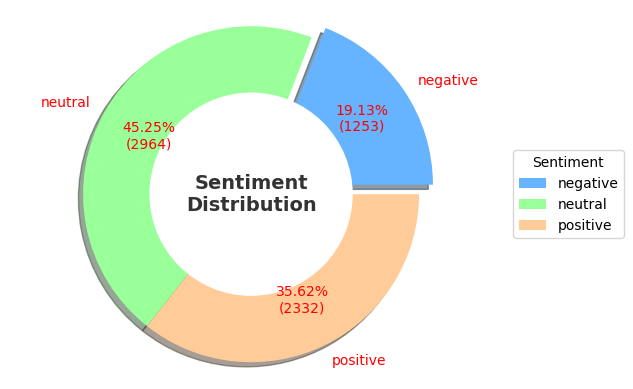

In [80]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

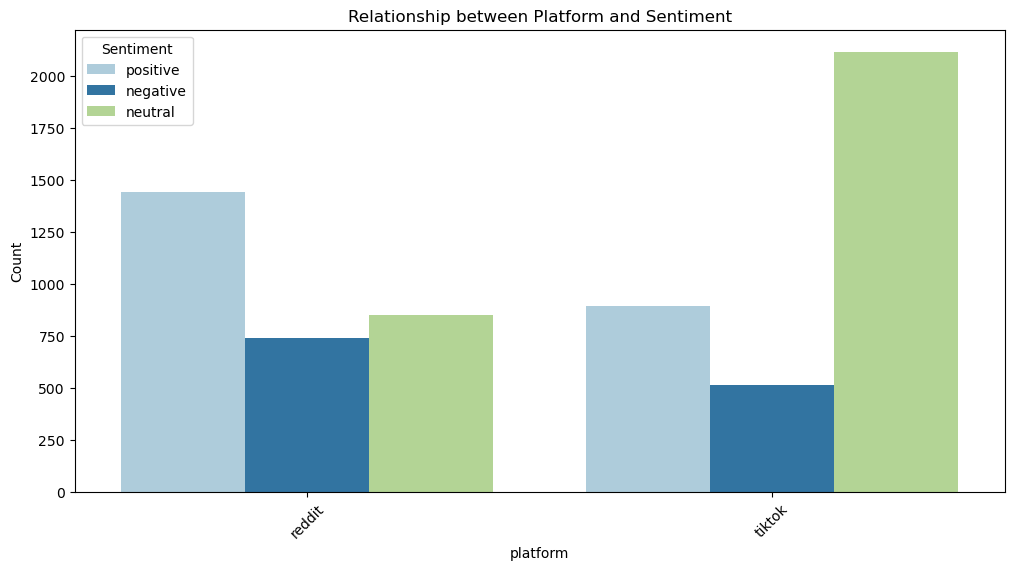

In [82]:
plt.figure(figsize=(12, 6))
sns.countplot(x='platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

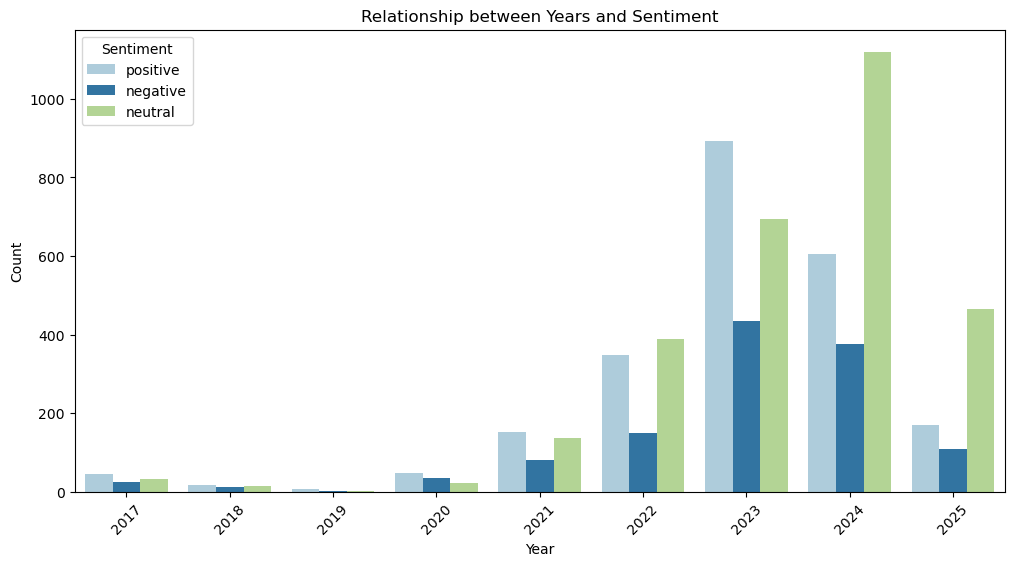

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

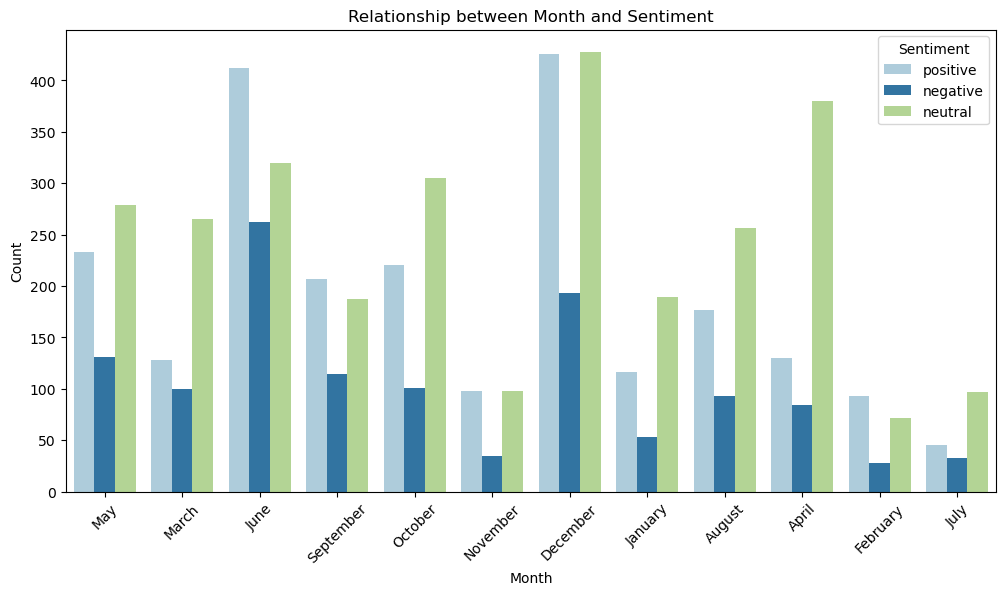

In [86]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month_name', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [88]:
'''
common words
'''
df1['temp_list'] = df1['clean_comment'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')


,Common_words,count
0,peopl,791
1,like,757
2,work,715
3,dont,689
4,get,685
5,go,622
6,pay,611
7,hospit,604
8,need,501
9,even,500


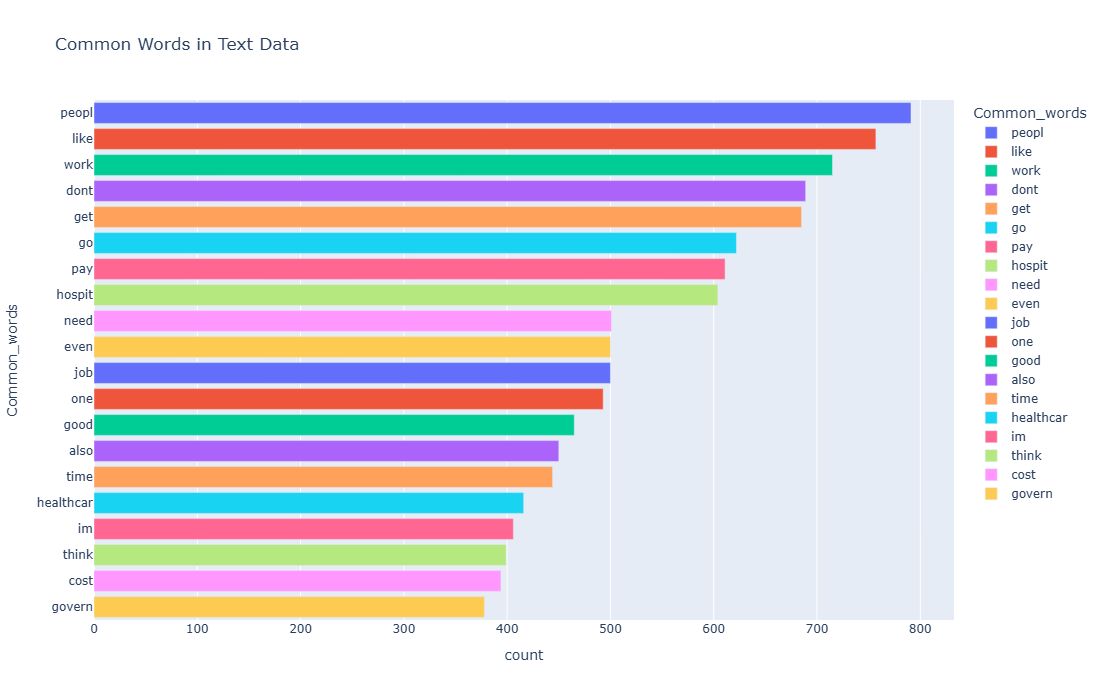

In [90]:
df1['temp_list'] = df1['clean_comment'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [92]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

In [94]:
#Positive Common Words

top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,like,601
1,peopl,436
2,work,425
3,get,417
4,good,400
5,dont,384
6,go,368
7,pay,329
8,job,307
9,one,298


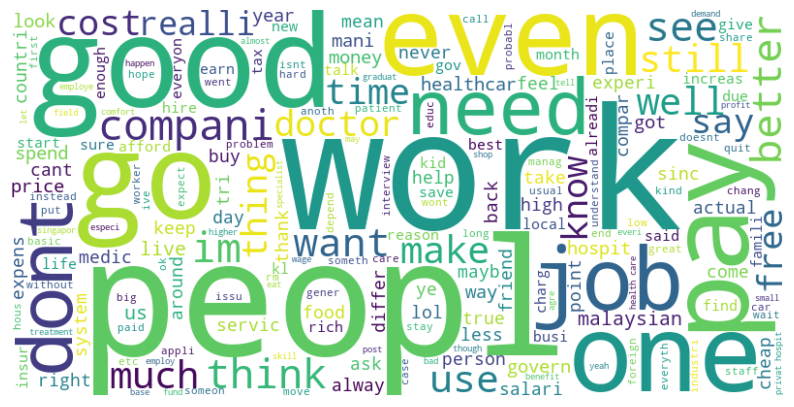

In [96]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [98]:
#Neutral Common Words
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,tak,190
1,nak,148
2,hospit,147
3,pun,133
4,kena,123
5,dia,109
6,need,94
7,dont,94
8,work,89
9,buat,89


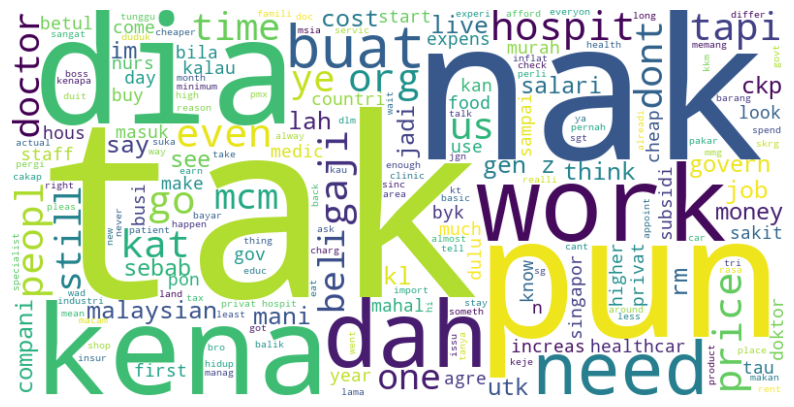

In [100]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [102]:
#Negative Common Words
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,peopl,274
1,pay,271
2,dont,211
3,work,201
4,get,187
5,hospit,181
6,go,171
7,time,149
8,job,138
9,need,137


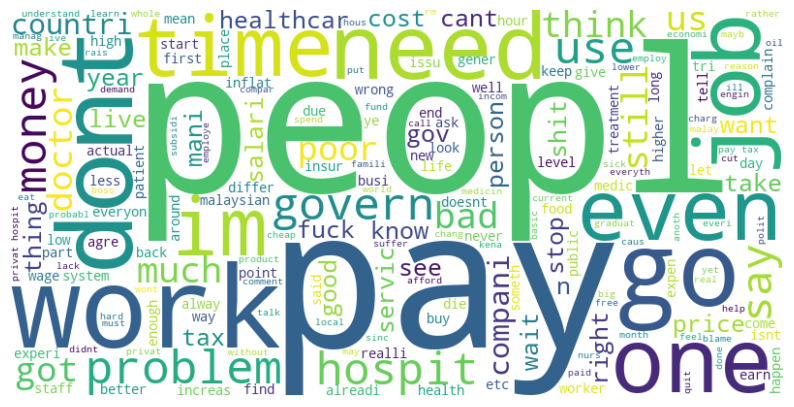

In [104]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [70]:
'''
Data Preparation
'''
df2 = df1.copy()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [ ]:
#Split Data
X = df2['clean_comment'].values
y = df2['Sentiment'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
'''
Modelling
'''
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
#Passive Aggressive Classifier
pac_classifier = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac_classifier.fit(X_train_tfidf, y_train)

In [ ]:
y_pred = pac_classifier.predict(X_test_tfidf)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [ ]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

In [ ]:
#Logistic Classifier
logistic_classifier = LogisticRegression(max_iter=50, random_state=42)
logistic_classifier.fit(X_train_tfidf, y_train)

In [ ]:
y_pred_logistic = logistic_classifier.predict(X_test_tfidf)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_rep_logistic = classification_report(y_test, y_pred_logistic)

In [ ]:
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logistic}")
print("Classification Report:\n", classification_rep_logistic)

In [ ]:
#Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_tfidf, y_train)

In [ ]:
y_pred_rf = random_forest_classifier.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

In [ ]:
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:\n", classification_rep_rf)

In [ ]:
#SVM Classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

In [ ]:
y_pred_svm = svm_classifier.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

In [ ]:
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:\n", classification_rep_svm)

In [ ]:
#Multinomial NB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

In [ ]:
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)

In [ ]:
print("\nMultinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:\n", classification_rep_nb)

In [ ]:
#Best Accuracy: Random Forest Classifier

In [ ]:
# Base Random Forest model
from scipy.stats import randint
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Define parameter distribution
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [ ]:
# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Fit to TF-IDF-transformed data
random_search.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = random_search.predict(X_test_tfidf)


In [ ]:
print("Best Parameters:", random_search.best_params_)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix for Random Forest Classifier Hyperparameter')
plt.show()

In [ ]:
#Second Best Modelling: Logistic Regression

In [ ]:
from scipy.stats import uniform
import pickle

In [ ]:
# Base model
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42)


In [ ]:
# Parameter distribution
param_dist = {
    'C': uniform(loc=0.001, scale=10),
    'penalty': ['l1', 'l2']
}

In [ ]:
# Randomized search
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Fit to TF-IDF-transformed data
random_search.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = random_search.predict(X_test_tfidf)

In [ ]:
print("Best Parameters:", random_search.best_params_)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Save the best model to a .pkl file
best_model = random_search.best_estimator_
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("Model saved as 'logistic_regression_model.pkl'.")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix for Logistic Regression Classifier Hyperparameter')
plt.show()

In [ ]:
#Best Modelling: Passive Aggressive Classifier

In [ ]:
param_dist = {
    'C': [0.1, 0.5, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

In [ ]:
pac_classifier = PassiveAggressiveClassifier(random_state=42)

randomized_search = RandomizedSearchCV(pac_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
randomized_search.fit(X_train_tfidf, y_train)

In [ ]:
best_params_randomized = randomized_search.best_params_
best_params_randomized

In [ ]:
best_pac_classifier_randomized = PassiveAggressiveClassifier(random_state=42, **best_params_randomized)
best_pac_classifier_randomized.fit(X_train_tfidf, y_train)

In [ ]:
y_pred_best_pac_randomized = best_pac_classifier_randomized.predict(X_test_tfidf)

In [ ]:
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_rep_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)

In [ ]:
print("Best PassiveAggressiveClassifier Model (RandomizedSearchCV):")
print(f"Best Hyperparameters: {best_params_randomized}")
print(f"Accuracy: {accuracy_best_pac_randomized}")
print("Classification Report:\n", classification_rep_best_pac_randomized)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()